In [1]:
# chapter 5 figures when we rotate the task, fixing a learner
import numpy as np
import math


#---------------------------------------------------
#--------------0 = A,B,C,D Pareto Optimal
#--------------1 = A,B,C Pareto Optimal
#--------------2 = A,C Pareto Optimal


p = 0.02
W = int(1/p)+1
tau = np.hstack([np.arange(0.2, 20.0, 0.4),np.arange(20,100,4), np.arange(100,500,20)])
N_tau = np.size(tau)
epsilon = np.arange(51)*0.02
epsilon = np.around(epsilon, decimals = 3)
N_eps = np.size(epsilon)

def softmax(R,T):
    P = np.zeros((W,N_tau,4))
    for n in range(N_tau):
        for w in range(W):
            weight = [w*p, 1.0-w*p]
            temp = (weight[0]*R + weight[1]*T)/tau[n]
            P[w,n,:] = np.exp(temp)/np.sum(np.exp(temp))
    learner = "Softmax One"
    return P, learner

def selective_attention(R,T):
    P = np.zeros((W,N_tau,4))
    for n in range(N_tau):
        ex_R = np.exp((R - np.max(R))/tau[n])
        ex_T = np.exp((T - np.max(T))/tau[n])
        weight_R = ex_R/np.sum(ex_R)
        weight_T = ex_T/np.sum(ex_T)
        for w in range(W):
            weight = [w*p,1.0-w*p]
            P[w,n,:] = weight[0]*weight_R + weight[1]*weight_T
    learner = "Softmax Two"
    return np.round(P,3), learner



def hypervolume(R,T, refpoint):
    P = np.zeros((W,N_tau,4))
    for n in range(N_tau):
        for w in range(W):
            temp = np.zeros(4)
            for i in range(4):
                temp[i] = pow(abs(R[i] - np.min(R) +refpoint[0]), w*p/tau[n])*pow(abs(T[i] - np.min(T)+refpoint[1]), (1-w*p)/tau[n])
            #print(temp)
            P[w,n,:] = temp/np.sum(temp)
    learner = "Hypervolume"
    return P, learner

def eps_greedy(R,T):
    P = np.zeros((W,N_eps,4))
    temp = np.zeros(4)
    for n in range(N_eps):
        for w in range(W):
            weight = [w*p, 1-w*p]
            for i in range(4):
                temp[i] = weight[0]*R[i] + weight[1]*T[i]
            k = np.argmax(temp)
            for i in range(4):
                if i == k:
                    P[w,n,i] = 1-0.75*epsilon[n]
                else:
                    P[w,n,i] = 0.25*epsilon[n]
    
    learner = "Epsilon-Greedy"
    return P, learner
        
def run(decision_maker, R,T, WEIGHT, TAU):
    if decision_maker!=eps_greedy:
        prob, learner_type = decision_maker(R,T)
        max_reward = np.max(R)
        max_threat = np.max(T)
        reward_regret = max_reward - np.dot(prob[WEIGHT,TAU], R)
        threat_regret = max_threat - np.dot(prob[WEIGHT,TAU], T)
    else:
        prob, learner_type = decision_maker(R,T)
        max_reward = np.max(R)
        max_threat = np.max(T)
        reward_regret = max_reward - np.dot(prob[WEIGHT,TAU], R)
        threat_regret = max_threat - np.dot(prob[WEIGHT,TAU], T)        
    return reward_regret, threat_regret

def run_all(decision_maker, R,T):
    if decision_maker!=eps_greedy:
        reward_regret = np.zeros((W,N_tau))
        threat_regret = np.zeros((W,N_tau))
        prob, learner_type = decision_maker(R,T)
        max_reward = np.max(R)
        max_threat = np.max(T)
        for w in range(W):
            for n in range(N_tau):
                reward_regret[w,n] = max_reward - np.dot(prob[w,n], R)
                threat_regret[w,n] = max_threat - np.dot(prob[w,n], T)
    else:
        reward_regret = np.zeros((W,N_eps))
        threat_regret = np.zeros((W,N_eps))
        prob, learner_type = decision_maker(R,T)
        max_reward = np.max(R)
        max_threat = np.max(T)
        for w in range(W):
            for n in range(N_eps):
                reward_regret[w,n] = max_reward - np.dot(prob[w,n], R)
                threat_regret[w,n] = max_threat - np.dot(prob[w,n], T)        
    return reward_regret, threat_regret



# helper rotator function here
# rotate point by angle based on center
def rotate(x, y, theta):
    L = len(x)
    p = np.array([x,y])
    #print(p)
    xx = np.mean(x)
    yy = np.mean(y)
    m = np.zeros((2,L))
    for l in range(L):
        m[0,l] = xx
        m[1,l] = yy
    #print(m)
    rot_matrix = np.array([[math.cos(theta), - math.sin(theta)],
                         [math.sin(theta), math.cos(theta)]])
    rotated = np.dot(rot_matrix, np.array([x,y]) - m) + m
    return rotated
rotate([0,1], [1,0], math.pi/2)



array([[0.00000000e+00, 1.00000000e+00],
       [5.55111512e-17, 1.00000000e+00]])

In [2]:
# given 4 points in reward-threat space, counts how many of them are on the Pareto boundary
def pareto_counter(x,y):
    count = 0
    for i in range(4):
        count_i = 0
        for j in range(4):
            if x[j]>x[i] and y[j]>y[i]:
                count_i+=1

        if count_i == 0:

            count+=1
    return count

pareto_counter([0,1,4,10],[0,1,4,10])

1

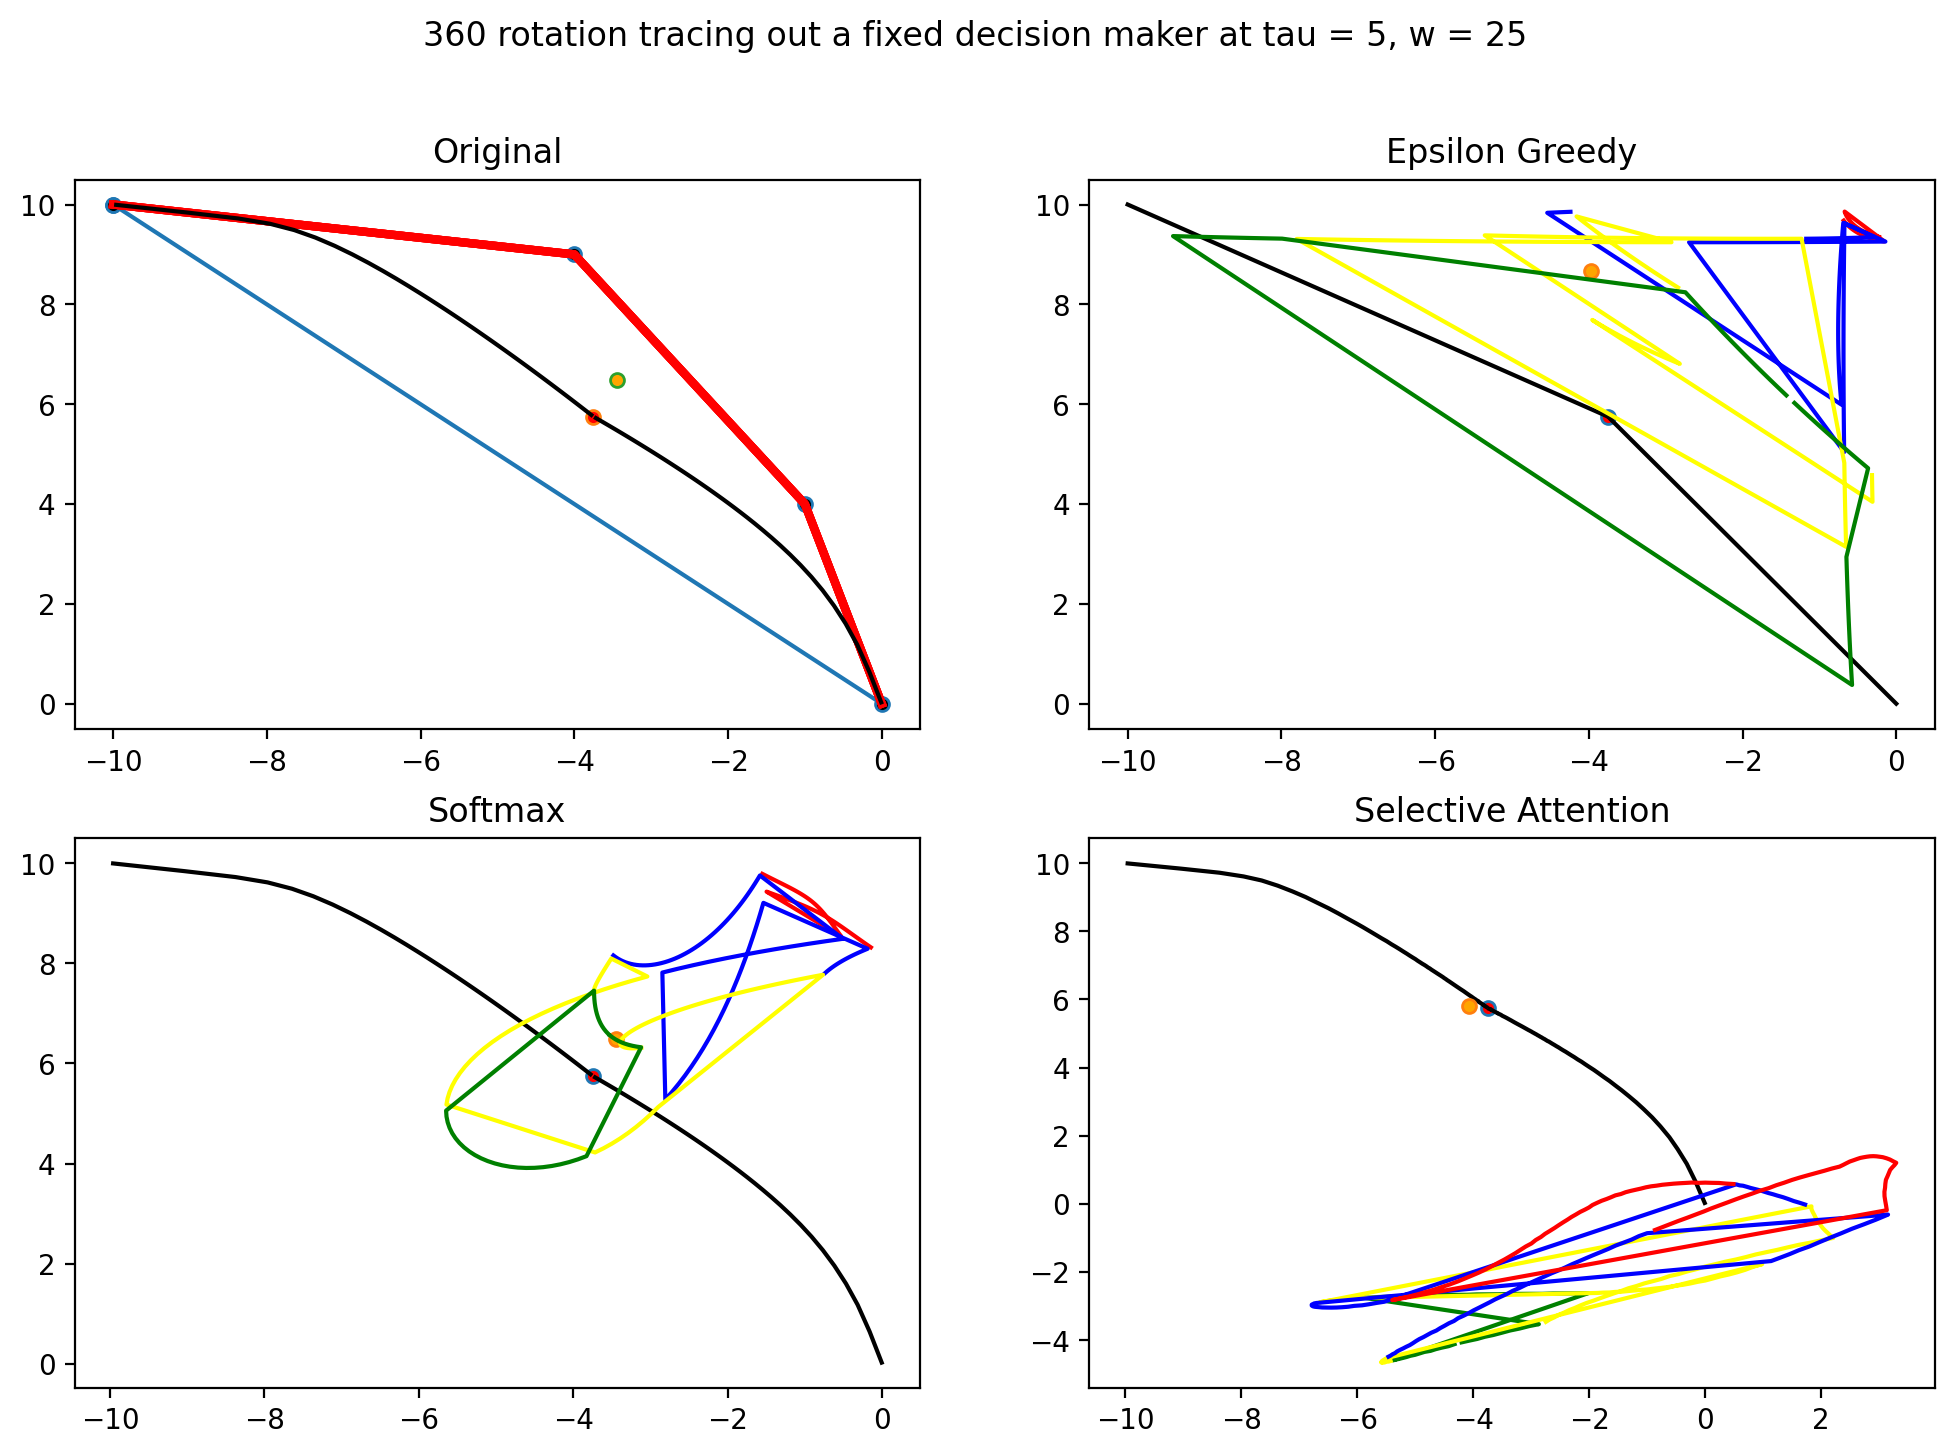

In [7]:
# plotting everything in reward-threat space 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from shapely.geometry import Polygon
figure(figsize=(12, 8), dpi=200)
TAU = 5
WEIGHT = 25
ROTATION_ANGLE = 360

plt.figure(1)
plt.suptitle("360 rotation tracing out a fixed decision maker at tau = "+str(TAU)+", w = " + str(WEIGHT))
#----------------------Simply Plotting the Feasible Region for all vertices are Pareto Optimal--------------------------
#----------------------k = 0--------------------------------------------------------------------------------------------
plt.subplot(2,2,1)

pure_thr = [0,1,4,10]
pure_rew = [10,6,1,0]
R = 10 - np.array(pure_rew)
T = 0 - np.array(pure_thr)


centroid = [np.mean(T), np.mean(R)]
coordinates = [[T[k], R[k]] for k in range(4)]
coordinates = sorted(coordinates)
coordinates.append(coordinates[0])
xs,ys = zip(*coordinates)
plt.plot(xs,ys, "-", marker = "o", markersize = 5, markerfacecolor = "black")
plt.plot(centroid[0],centroid[1],"-", marker = "o", markersize = 5, markerfacecolor = "red")
plt.title("Original")
for i in range(4):
    plt.plot(T, R, color = 'red', linewidth = 3)
    
reward_regret, threat_regret = run_all(softmax, R, T)
X = 0 - threat_regret
Y = 10 - reward_regret

plt.plot(X[0,:], Y[0,:], color = 'black')
plt.plot(X[-1,:], Y[-1,:], color = 'black')
plt.plot(X[WEIGHT, TAU],Y[WEIGHT, TAU], marker = "o", markersize = 5, markerfacecolor = "orange")  
#print(X,Y)
#--------------------------------------------------------------------------------------------------------------------------
# rotating by 1 degree and track fixed learner - selective attention
plt.subplot(2,2,2)

R_regret = np.zeros(ROTATION_ANGLE)
T_regret = np.zeros(ROTATION_ANGLE)
y = np.zeros((4,ROTATION_ANGLE))
x = np.zeros((4,ROTATION_ANGLE))


centroid = [np.mean(T), np.mean(R)]
coordinates = [[T[k], R[k]] for k in range(4)]
coordinates = sorted(coordinates)
coordinates.append(coordinates[0])
xs,ys = zip(*coordinates)
# plt.plot(xs,ys, "-", marker = "o", markersize = 5, markerfacecolor = "black")
plt.plot(centroid[0],centroid[1],"-", marker = "o", markersize = 5, markerfacecolor = "red")
plt.title("Epsilon Greedy")

for i in range(ROTATION_ANGLE):
    d = float(i/180)*math.pi
    y[:,i], x[:,i] = rotate(T,R, d)
    yy,xx = run(eps_greedy, y[:,i], x[:,i], WEIGHT, TAU)
    R_regret[i] = yy
    T_regret[i] = xx   

reward_regret, threat_regret = run_all(eps_greedy, R, T)
X = 0 - threat_regret
Y = 10 - reward_regret

plt.plot(X[0,:], Y[0,:], color = 'black')
plt.plot(X[-1,:], Y[-1,:], color = 'black')
plt.plot(X[WEIGHT, TAU],Y[WEIGHT, TAU], marker = "o", markersize = 5, markerfacecolor = "orange") 

# color code by number of pareto optimal points
x_coord,y_coord = ([[None], [None], [None], [None]] for i in range(2))
T_regret = 0-T_regret
R_regret = 10-R_regret
for i in range(ROTATION_ANGLE):
    #print(pareto_counter(x[:,i], y[:,i]))
    if pareto_counter(x[:,i], y[:,i]) == 1:
        x_coord[0].append(T_regret[i])
        y_coord[0].append(R_regret[i])
    elif pareto_counter(x[:,i], y[:,i]) == 2:
        x_coord[1].append(T_regret[i])
        y_coord[1].append(R_regret[i])
    elif pareto_counter(x[:,i], y[:,i]) == 3:
        x_coord[2].append(T_regret[i])
        y_coord[2].append(R_regret[i])
    else:
        x_coord[3].append(T_regret[i])
        y_coord[3].append(R_regret[i])

colors = ["red", "blue", "yellow", "green"]
for i in range(4):
    plt.plot(np.array(x_coord[i]), np.array(y_coord[i]), color = colors[i])
#--------------------------------------------------------------------------------------------------------------------------
# rotating by 1 degree and track fixed learner - softmax
plt.subplot(2,2,3)
R_regret = np.zeros(ROTATION_ANGLE)
T_regret = np.zeros(ROTATION_ANGLE)

centroid = [np.mean(T), np.mean(R)]
coordinates = [[T[k], R[k]] for k in range(4)]
coordinates = sorted(coordinates)
coordinates.append(coordinates[0])
xs,ys = zip(*coordinates)
# plt.plot(xs,ys, "-", marker = "o", markersize = 5, markerfacecolor = "black")
plt.plot(centroid[0],centroid[1],"-", marker = "o", markersize = 5, markerfacecolor = "red")
plt.title("Softmax")

for i in range(ROTATION_ANGLE):
    d = float(i/180)*math.pi
    y[:,i], x[:,i] = rotate(T,R, d)
    yy,xx = run(softmax, y[:,i], x[:,i], WEIGHT, TAU)
    R_regret[i] = yy
    T_regret[i] = xx   

reward_regret, threat_regret = run_all(softmax, R, T)
X = 0 - threat_regret
Y = 10 - reward_regret

plt.plot(X[0,:], Y[0,:], color = 'black')
plt.plot(X[-1,:], Y[-1,:], color = 'black')
plt.plot(X[WEIGHT, TAU],Y[WEIGHT, TAU], marker = "o", markersize = 5, markerfacecolor = "orange") 

# color code by number of pareto optimal points
x_coord,y_coord = ([[None], [None], [None], [None]] for i in range(2))
T_regret = 0-T_regret
R_regret = 10-R_regret
for i in range(ROTATION_ANGLE):
    #print(pareto_counter(x[:,i], y[:,i]))
    if pareto_counter(x[:,i], y[:,i]) == 1:
        x_coord[0].append(T_regret[i])
        y_coord[0].append(R_regret[i])
    elif pareto_counter(x[:,i], y[:,i]) == 2:
        x_coord[1].append(T_regret[i])
        y_coord[1].append(R_regret[i])
    elif pareto_counter(x[:,i], y[:,i]) == 3:
        x_coord[2].append(T_regret[i])
        y_coord[2].append(R_regret[i])
    else:
        x_coord[3].append(T_regret[i])
        y_coord[3].append(R_regret[i])

colors = ["red", "blue", "yellow", "green"]
for i in range(4):
    plt.plot(np.array(x_coord[i]), np.array(y_coord[i]), color = colors[i])
#--------------------------------------------------------------------------------------------------------------------------
# rotating by 1 degree and track fixed learner - eps-greedy
plt.subplot(2,2,4)
R_regret = np.zeros(ROTATION_ANGLE)
T_regret = np.zeros(ROTATION_ANGLE)

centroid = [np.mean(T), np.mean(R)]
coordinates = [[T[k], R[k]] for k in range(4)]
coordinates = sorted(coordinates)
coordinates.append(coordinates[0])
xs,ys = zip(*coordinates)
# plt.plot(xs,ys, "-", marker = "o", markersize = 5, markerfacecolor = "black")
plt.plot(centroid[0],centroid[1],"-", marker = "o", markersize = 5, markerfacecolor = "red")
plt.title("Selective Attention")

for i in range(ROTATION_ANGLE):
    d = float(i/180)*math.pi
    y[:,i], x[:,i] = rotate(T,R, d)
    yy,xx = run(selective_attention, y[:,i], x[:,i], WEIGHT, TAU)
    R_regret[i] = yy
    T_regret[i] = xx   
max_x = np.amin(x,axis = 0)
max_y = np.amax(y,axis = 0)
reward_regret, threat_regret = run_all(selective_attention, R, T)
X = 0 - threat_regret
Y = 10 - reward_regret

plt.plot(X[0,:], Y[0,:], color = 'black')
plt.plot(X[-1,:], Y[-1,:], color = 'black')
plt.plot(X[WEIGHT, TAU],Y[WEIGHT, TAU], marker = "o", markersize = 5, markerfacecolor = "orange") 

# color code by number of pareto optimal points
x_coord,y_coord = ([[None], [None], [None], [None]] for i in range(2))
T_regret = max_x-T_regret
R_regret = max_y-R_regret
for i in range(ROTATION_ANGLE):
    #print(pareto_counter(x[:,i], y[:,i]))
    if pareto_counter(x[:,i], y[:,i]) == 1:
        x_coord[0].append(T_regret[i])
        y_coord[0].append(R_regret[i])
    elif pareto_counter(x[:,i], y[:,i]) == 2:
        x_coord[1].append(T_regret[i])
        y_coord[1].append(R_regret[i])
    elif pareto_counter(x[:,i], y[:,i]) == 3:
        x_coord[2].append(T_regret[i])
        y_coord[2].append(R_regret[i])
    else:
        x_coord[3].append(T_regret[i])
        y_coord[3].append(R_regret[i])
colors = ["red", "blue", "yellow", "green"]
for i in range(4):
    plt.plot(np.array(x_coord[3-i]), np.array(y_coord[3-i]), color = colors[3-i])

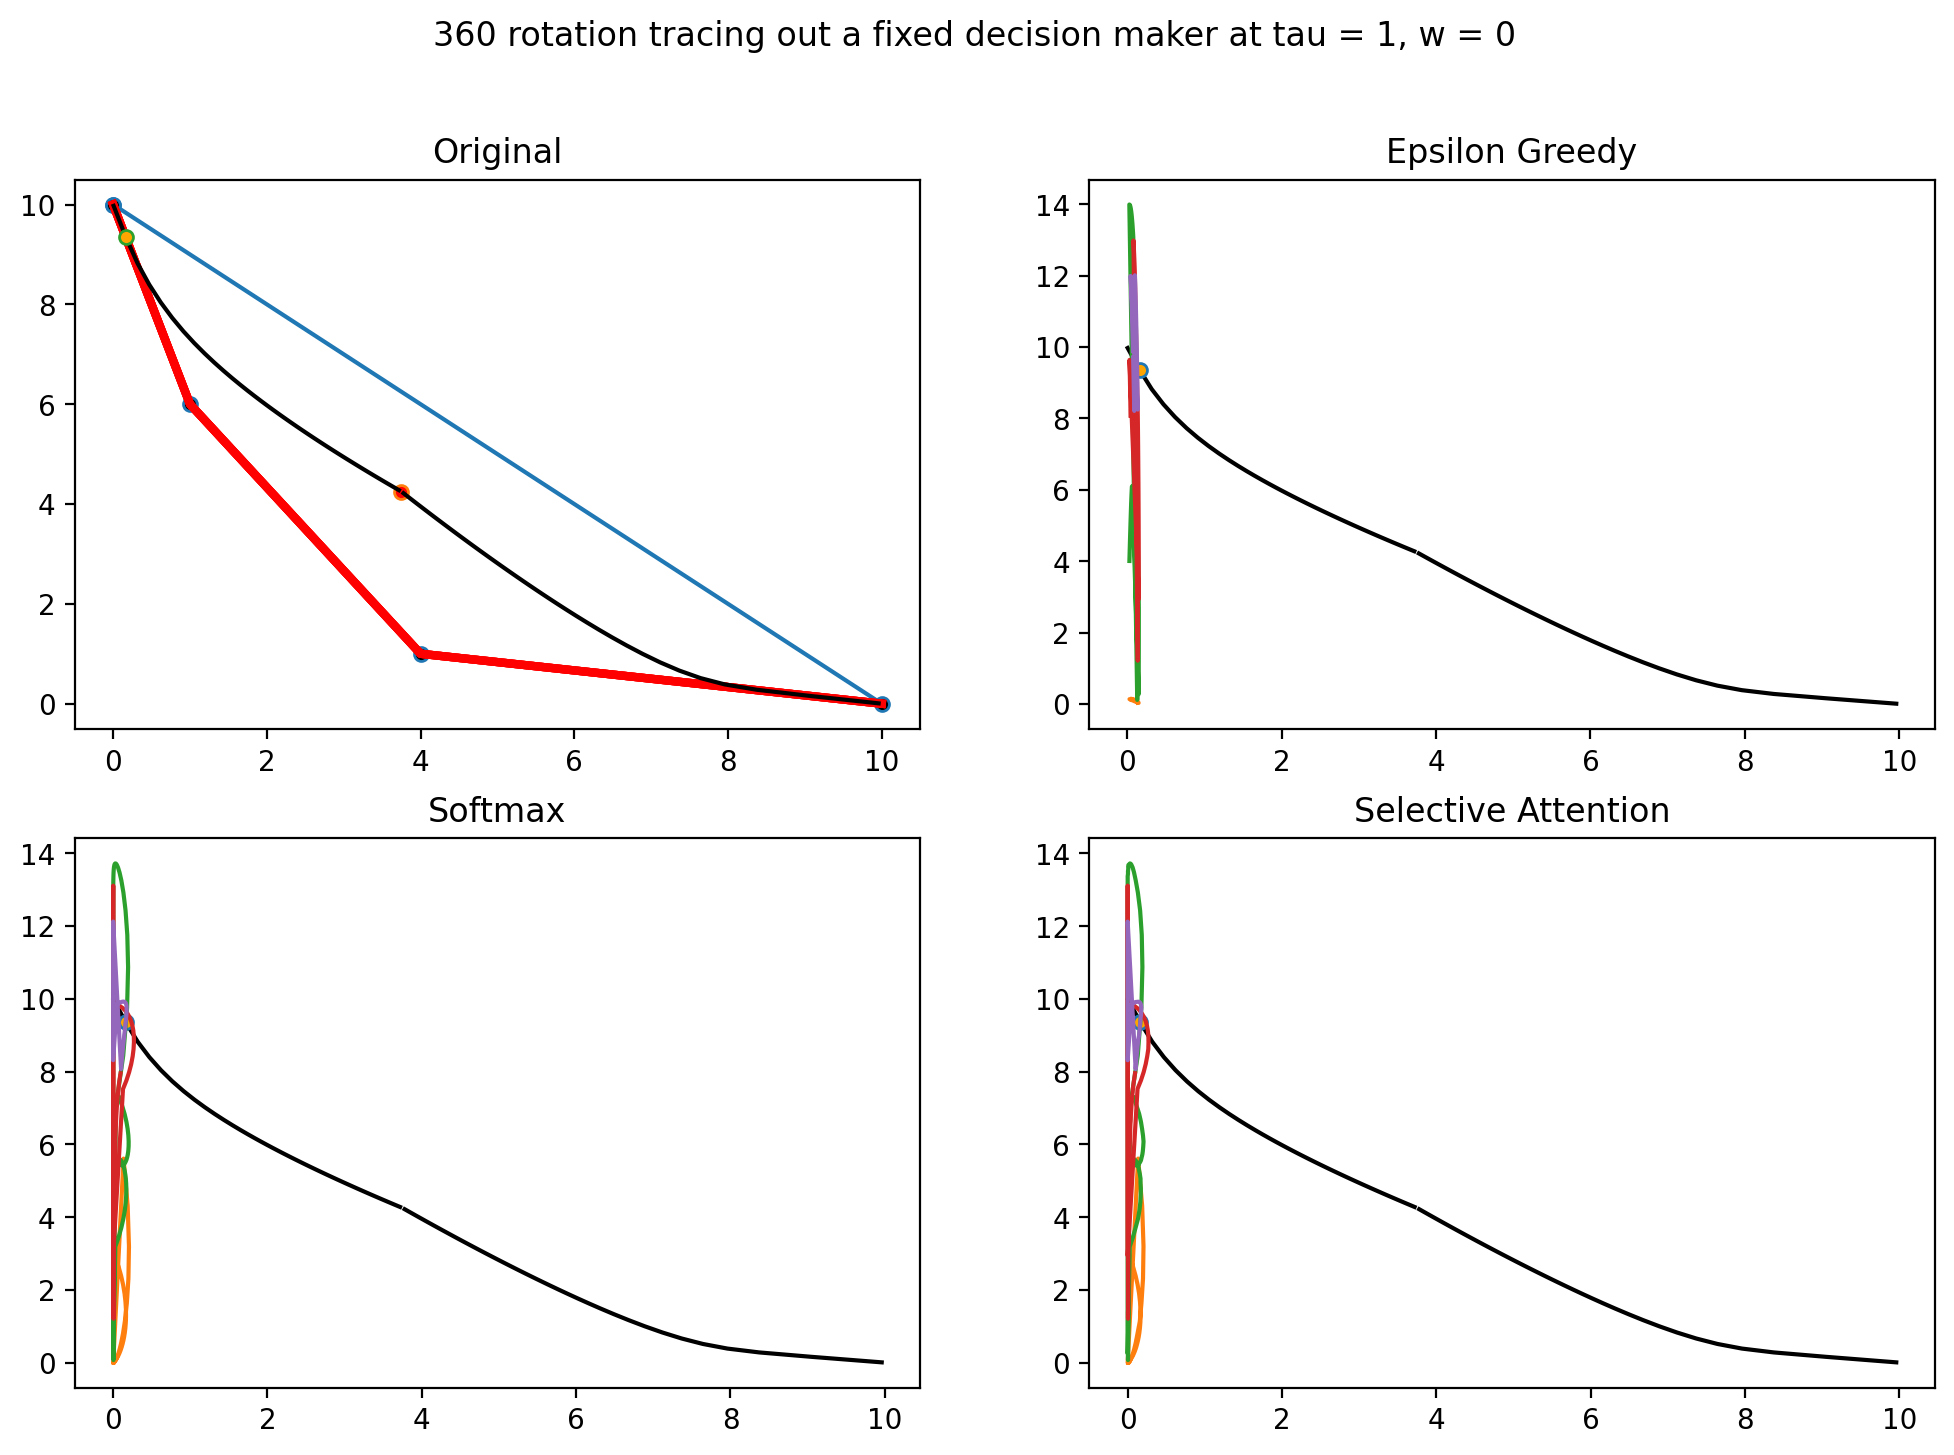

In [4]:
# plotting everything in REGRET space 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from shapely.geometry import Polygon
figure(figsize=(12, 8), dpi=200)
TAU = 1
WEIGHT = 0
ROTATION_ANGLE = 360

plt.figure(1)
plt.suptitle("360 rotation tracing out a fixed decision maker at tau = "+str(TAU)+", w = " + str(WEIGHT))
#----------------------Simply Plotting the Feasible Region for all vertices are Pareto Optimal--------------------------
#----------------------k = 0--------------------------------------------------------------------------------------------
plt.subplot(2,2,1)

pure_thr = [0,1,4,10]
pure_rew = [10,6,1,0]
R = 10 - np.array(pure_rew)
T = 0 - np.array(pure_thr)


centroid = [np.mean(pure_thr), np.mean(pure_rew)]
coordinates = [[pure_thr[k], pure_rew[k]] for k in range(4)]
coordinates = sorted(coordinates)
coordinates.append(coordinates[0])
xs,ys = zip(*coordinates)
plt.plot(xs,ys, "-", marker = "o", markersize = 5, markerfacecolor = "black")
plt.plot(centroid[0],centroid[1],"-", marker = "o", markersize = 5, markerfacecolor = "red")
plt.title("Original")
for i in range(4):
    plt.plot(pure_thr, pure_rew, color = 'red', linewidth = 3)
    
reward_regret, threat_regret = run_all(softmax, R, T)
X = threat_regret
Y = reward_regret

plt.plot(X[0,:], Y[0,:], color = 'black')
plt.plot(X[-1,:], Y[-1,:], color = 'black')
plt.plot(X[WEIGHT, TAU],Y[WEIGHT, TAU], marker = "o", markersize = 5, markerfacecolor = "orange")  
#print(X,Y)
#--------------------------------------------------------------------------------------------------------------------------
# rotating by 1 degree and track fixed learner - selective attention
plt.subplot(2,2,2)

R_regret = np.zeros(ROTATION_ANGLE)
T_regret = np.zeros(ROTATION_ANGLE)
y = np.zeros((4,ROTATION_ANGLE))
x = np.zeros((4,ROTATION_ANGLE))


centroid = [np.mean(pure_thr), np.mean(pure_rew)]
coordinates = [[pure_thr[k], pure_rew[k]] for k in range(4)]
coordinates = sorted(coordinates)
coordinates.append(coordinates[0])
xs,ys = zip(*coordinates)
# plt.plot(xs,ys, "-", marker = "o", markersize = 5, markerfacecolor = "black")
# plt.plot(centroid[0],centroid[1],"-", marker = "o", markersize = 5, markerfacecolor = "red")
plt.title("Epsilon Greedy")


for i in range(ROTATION_ANGLE):
    d = float(i/180)*math.pi
    y[:,i], x[:,i] = rotate(R,T, d)
    yy,xx = run(eps_greedy, y[:,i], x[:,i], WEIGHT, TAU)
    R_regret[i] = yy
    T_regret[i] = xx   

reward_regret, threat_regret = run_all(eps_greedy, R, T)

plt.plot(X[0,:], Y[0,:], color = 'black')
plt.plot(X[-1,:], Y[-1,:], color = 'black')
plt.plot(X[WEIGHT, TAU],Y[WEIGHT, TAU], marker = "o", markersize = 5, markerfacecolor = "orange") 

# color code by number of pareto optimal points
x_coord,y_coord = ([[None], [None], [None], [None]] for i in range(2))

for i in range(ROTATION_ANGLE):
    #print(pareto_counter(x[:,i], y[:,i]))
    if pareto_counter(x[:,i], y[:,i]) == 1:
        x_coord[0].append(T_regret[i])
        y_coord[0].append(R_regret[i])
    elif pareto_counter(x[:,i], y[:,i]) == 2:
        x_coord[1].append(T_regret[i])
        y_coord[1].append(R_regret[i])
    elif pareto_counter(x[:,i], y[:,i]) == 3:
        x_coord[2].append(T_regret[i])
        y_coord[2].append(R_regret[i])
    else:
        x_coord[3].append(T_regret[i])
        y_coord[3].append(R_regret[i])

for i in range(4):
    plt.plot(np.array(x_coord[i]), np.array(y_coord[i]))
#------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------
# rotating by 1 degree and track fixed learner - softmax
plt.subplot(2,2,3)
R_regret = np.zeros(ROTATION_ANGLE)
T_regret = np.zeros(ROTATION_ANGLE)

centroid = [np.mean(pure_thr), np.mean(pure_rew)]
coordinates = [[pure_thr[k], pure_rew[k]] for k in range(4)]
coordinates = sorted(coordinates)
coordinates.append(coordinates[0])
xs,ys = zip(*coordinates)
# plt.plot(xs,ys, "-", marker = "o", markersize = 5, markerfacecolor = "black")
# plt.plot(centroid[0],centroid[1],"-", marker = "o", markersize = 5, markerfacecolor = "red")
plt.title("Softmax")

for i in range(ROTATION_ANGLE):
    d = float(i/180)*math.pi
    y[:,i], x[:,i] = rotate(R,T, d)
    yy,xx = run(softmax, y[:,i], x[:,i], WEIGHT, TAU)
    R_regret[i] = yy
    T_regret[i] = xx   

reward_regret, threat_regret = run_all(softmax, R, T)

plt.plot(X[0,:], Y[0,:], color = 'black')
plt.plot(X[-1,:], Y[-1,:], color = 'black')
plt.plot(X[WEIGHT, TAU],Y[WEIGHT, TAU], marker = "o", markersize = 5, markerfacecolor = "orange") 

# color code by number of pareto optimal points
x_coord,y_coord = ([[None], [None], [None], [None]] for i in range(2))

for i in range(ROTATION_ANGLE):
    #print(pareto_counter(x[:,i], y[:,i]))
    if pareto_counter(x[:,i], y[:,i]) == 1:
        x_coord[0].append(T_regret[i])
        y_coord[0].append(R_regret[i])
    elif pareto_counter(x[:,i], y[:,i]) == 2:
        x_coord[1].append(T_regret[i])
        y_coord[1].append(R_regret[i])
    elif pareto_counter(x[:,i], y[:,i]) == 3:
        x_coord[2].append(T_regret[i])
        y_coord[2].append(R_regret[i])
    else:
        x_coord[3].append(T_regret[i])
        y_coord[3].append(R_regret[i])

for i in range(4):
    plt.plot(np.array(x_coord[i]), np.array(y_coord[i]))    
#--------------------------------------------------------------------------------------------------------------------------
# rotating by 1 degree and track fixed learner - eps-greedy
plt.subplot(2,2,4)
R_regret = np.zeros(ROTATION_ANGLE)
T_regret = np.zeros(ROTATION_ANGLE)

centroid = [np.mean(pure_thr), np.mean(pure_rew)]
coordinates = [[pure_thr[k], pure_rew[k]] for k in range(4)]
coordinates = sorted(coordinates)
coordinates.append(coordinates[0])
xs,ys = zip(*coordinates)
# plt.plot(xs,ys, "-", marker = "o", markersize = 5, markerfacecolor = "black")
# plt.plot(centroid[0],centroid[1],"-", marker = "o", markersize = 5, markerfacecolor = "red")
plt.title("Selective Attention")

for i in range(ROTATION_ANGLE):
    d = float(i/180)*math.pi
    y[:,i], x[:,i] = rotate(R,T, d)
    yy,xx = run(selective_attention, y[:,i], x[:,i], WEIGHT, TAU)
    R_regret[i] = yy
    T_regret[i] = xx   

reward_regret, threat_regret = run_all(selective_attention, R, T)

plt.plot(X[0,:], Y[0,:], color = 'black')
plt.plot(X[-1,:], Y[-1,:], color = 'black')
plt.plot(X[WEIGHT, TAU],Y[WEIGHT, TAU], marker = "o", markersize = 5, markerfacecolor = "orange") 

# color code by number of pareto optimal points
x_coord,y_coord = ([[None], [None], [None], [None]] for i in range(2))

for i in range(ROTATION_ANGLE):
    #print(pareto_counter(x[:,i], y[:,i]))
    if pareto_counter(x[:,i], y[:,i]) == 1:
        x_coord[0].append(T_regret[i])
        y_coord[0].append(R_regret[i])
    elif pareto_counter(x[:,i], y[:,i]) == 2:
        x_coord[1].append(T_regret[i])
        y_coord[1].append(R_regret[i])
    elif pareto_counter(x[:,i], y[:,i]) == 3:
        x_coord[2].append(T_regret[i])
        y_coord[2].append(R_regret[i])
    else:
        x_coord[3].append(T_regret[i])
        y_coord[3].append(R_regret[i])

for i in range(4):
    plt.plot(np.array(x_coord[i]), np.array(y_coord[i])) 